##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 3s

  5505024/228813984 [..............................] - ETA: 2s

  8396800/228813984 [>.............................] - ETA: 17s

 22405120/228813984 [=>............................] - ETA: 6s 

 25174016/228813984 [==>...........................] - ETA: 9s

 40853504/228813984 [====>.........................] - ETA: 5s

 41951232/228813984 [====>.........................] - ETA: 6s

 56123392/228813984 [======>.......................] - ETA: 4s

 58728448/228813984 [======>.......................] - ETA: 5s

 72908800/228813984 [========>.....................] - ETA: 4s

 86802432/228813984 [==========>...................] - ETA: 3s

 92282880/228813984 [===========>..................] - ETA: 4s

105816064/228813984 [============>.................] - ETA: 3s

121856000/228813984 [==============>...............] - ETA: 2s

125837312/228813984 [===============>..............] - ETA: 3s

139337728/228813984 [=================>............] - ETA: 2s

153354240/228813984 [===================>..........] - ETA: 2s

167477248/228813984 [====================>.........] - ETA: 1s

176168960/228813984 [======================>.......] - ETA: 1s

188489728/228813984 [=======================>......] - ETA: 1s

203112448/228813984 [=========================>....] - ETA: 0s

217358336/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 6s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

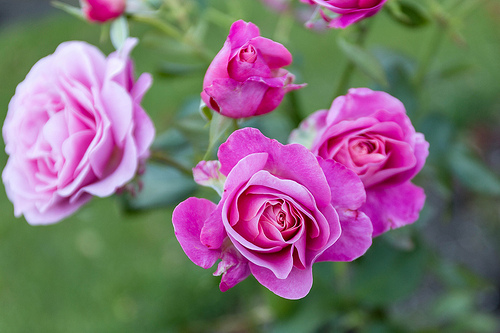

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

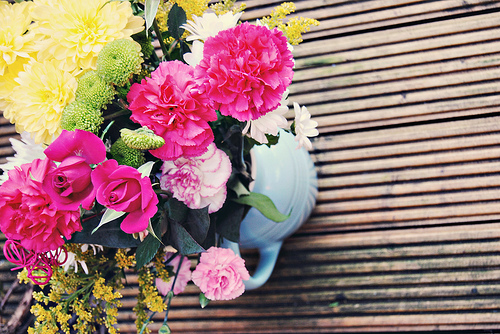

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

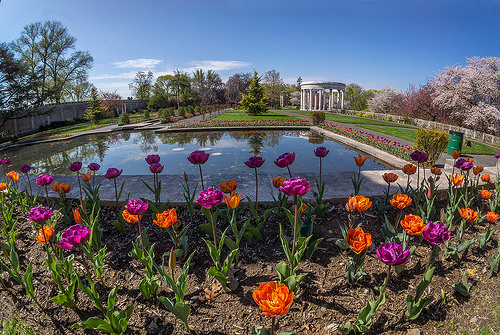

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

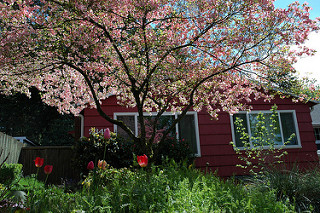

In [8]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

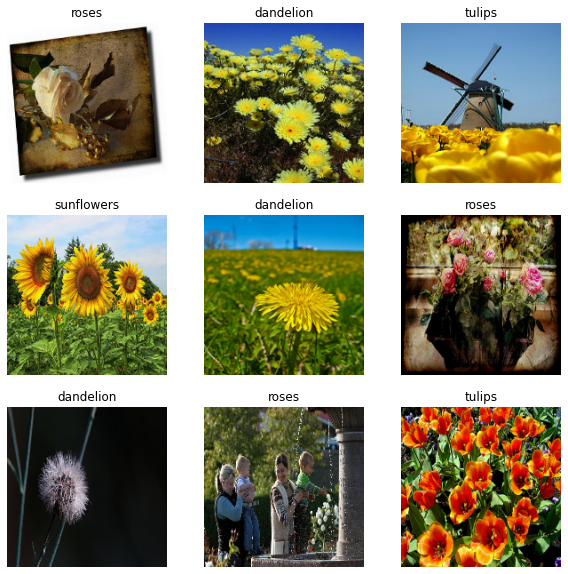

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9870374


Or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 0s - loss: 1.5900 - accuracy: 0.3438

 7/92 [=>............................] - ETA: 0s - loss: 2.9549 - accuracy: 0.1964

13/92 [===>..........................] - ETA: 0s - loss: 2.3429 - accuracy: 0.1875

14/92 [===>..........................] - ETA: 0s - loss: 2.3031 - accuracy: 0.1818

20/92 [=====>........................] - ETA: 0s - loss: 2.0883 - accuracy: 0.1883

26/92 [=======>......................] - ETA: 0s - loss: 1.9707 - accuracy: 0.2124

32/92 [=========>....................] - ETA: 0s - loss: 1.8939 - accuracy: 0.2234

38/92 [===========>..................] - ETA: 0s - loss: 1.8327 - accuracy: 0.2608

44/92 [=============>................] - ETA: 0s - loss: 1.7823 - accuracy: 0.2743

50/92 [===============>..............] - ETA: 0s - loss: 1.7385 - accuracy: 0.2902

57/92 [=================>............] - ETA: 0s - loss: 1.6907 - accuracy: 0.3100

64/92 [===================>..........] - ETA: 0s - loss: 1.6584 - accuracy: 0.3157

71/92 [======================>.......] - ETA: 0s - loss: 1.6178 - accuracy: 0.3313

77/92 [========================>.....] - ETA: 0s - loss: 1.5829 - accuracy: 0.3436

83/92 [==========================>...] - ETA: 0s - loss: 1.5582 - accuracy: 0.3516

90/92 [============================>.] - ETA: 0s - loss: 1.5314 - accuracy: 0.3625

92/92 [==============================] - 2s 26ms/step - loss: 1.5272 - accuracy: 0.3644 - val_loss: 1.1902 - val_accuracy: 0.4932


Epoch 2/10
 1/92 [..............................] - ETA: 0s - loss: 1.3348 - accuracy: 0.4062

 7/92 [=>............................] - ETA: 0s - loss: 1.1648 - accuracy: 0.5089

13/92 [===>..........................] - ETA: 0s - loss: 1.1218 - accuracy: 0.5409

19/92 [=====>........................] - ETA: 0s - loss: 1.1100 - accuracy: 0.5345

26/92 [=======>......................] - ETA: 0s - loss: 1.1193 - accuracy: 0.5264

32/92 [=========>....................] - ETA: 0s - loss: 1.1300 - accuracy: 0.5215

38/92 [===========>..................] - ETA: 0s - loss: 1.1298 - accuracy: 0.5247

44/92 [=============>................] - ETA: 0s - loss: 1.1271 - accuracy: 0.5213

50/92 [===============>..............] - ETA: 0s - loss: 1.1304 - accuracy: 0.5275

56/92 [=================>............] - ETA: 0s - loss: 1.1264 - accuracy: 0.5296

62/92 [===================>..........] - ETA: 0s - loss: 1.1261 - accuracy: 0.5333

68/92 [=====================>........] - ETA: 0s - loss: 1.1287 - accuracy: 0.5349

75/92 [=======================>......] - ETA: 0s - loss: 1.1145 - accuracy: 0.5446

81/92 [=========================>....] - ETA: 0s - loss: 1.1085 - accuracy: 0.5463

87/92 [===========================>..] - ETA: 0s - loss: 1.1076 - accuracy: 0.5431

92/92 [==============================] - 1s 10ms/step - loss: 1.0988 - accuracy: 0.5490 - val_loss: 0.9884 - val_accuracy: 0.6035


Epoch 3/10


 1/92 [..............................] - ETA: 0s - loss: 1.0566 - accuracy: 0.5312

 7/92 [=>............................] - ETA: 0s - loss: 0.9826 - accuracy: 0.5938

13/92 [===>..........................] - ETA: 0s - loss: 0.9745 - accuracy: 0.6250

19/92 [=====>........................] - ETA: 0s - loss: 0.9572 - accuracy: 0.6382

25/92 [=======>......................] - ETA: 0s - loss: 0.9417 - accuracy: 0.6375

31/92 [=========>....................] - ETA: 0s - loss: 0.9475 - accuracy: 0.6331

37/92 [===========>..................] - ETA: 0s - loss: 0.9284 - accuracy: 0.6444

43/92 [=============>................] - ETA: 0s - loss: 0.9210 - accuracy: 0.6504

50/92 [===============>..............] - ETA: 0s - loss: 0.9219 - accuracy: 0.6520

56/92 [=================>............] - ETA: 0s - loss: 0.9215 - accuracy: 0.6508

62/92 [===================>..........] - ETA: 0s - loss: 0.9191 - accuracy: 0.6544

68/92 [=====================>........] - ETA: 0s - loss: 0.9148 - accuracy: 0.6522

74/92 [=======================>......] - ETA: 0s - loss: 0.9157 - accuracy: 0.6500

81/92 [=========================>....] - ETA: 0s - loss: 0.9129 - accuracy: 0.6517

87/92 [===========================>..] - ETA: 0s - loss: 0.9092 - accuracy: 0.6549

92/92 [==============================] - 1s 10ms/step - loss: 0.9061 - accuracy: 0.6540 - val_loss: 1.0288 - val_accuracy: 0.5858


Epoch 4/10


 1/92 [..............................] - ETA: 0s - loss: 0.6333 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 0s - loss: 0.6725 - accuracy: 0.7902

13/92 [===>..........................] - ETA: 0s - loss: 0.6989 - accuracy: 0.7740

19/92 [=====>........................] - ETA: 0s - loss: 0.7281 - accuracy: 0.7500

26/92 [=======>......................] - ETA: 0s - loss: 0.7388 - accuracy: 0.7354

32/92 [=========>....................] - ETA: 0s - loss: 0.7336 - accuracy: 0.7333

38/92 [===========>..................] - ETA: 0s - loss: 0.7364 - accuracy: 0.7351

45/92 [=============>................] - ETA: 0s - loss: 0.7241 - accuracy: 0.7416

52/92 [===============>..............] - ETA: 0s - loss: 0.7141 - accuracy: 0.7458

58/92 [=================>............] - ETA: 0s - loss: 0.7110 - accuracy: 0.7413

65/92 [====================>.........] - ETA: 0s - loss: 0.7145 - accuracy: 0.7389

71/92 [======================>.......] - ETA: 0s - loss: 0.7171 - accuracy: 0.7359

78/92 [========================>.....] - ETA: 0s - loss: 0.7202 - accuracy: 0.7335

84/92 [==========================>...] - ETA: 0s - loss: 0.7279 - accuracy: 0.7269

90/92 [============================>.] - ETA: 0s - loss: 0.7310 - accuracy: 0.7235

92/92 [==============================] - 1s 10ms/step - loss: 0.7326 - accuracy: 0.7248 - val_loss: 0.9639 - val_accuracy: 0.6226


Epoch 5/10
 1/92 [..............................] - ETA: 0s - loss: 0.5068 - accuracy: 0.9062

 7/92 [=>............................] - ETA: 0s - loss: 0.5835 - accuracy: 0.8304

13/92 [===>..........................] - ETA: 0s - loss: 0.5387 - accuracy: 0.8317

19/92 [=====>........................] - ETA: 0s - loss: 0.5324 - accuracy: 0.8273

25/92 [=======>......................] - ETA: 0s - loss: 0.5317 - accuracy: 0.8275

31/92 [=========>....................] - ETA: 0s - loss: 0.5279 - accuracy: 0.8306

37/92 [===========>..................] - ETA: 0s - loss: 0.5103 - accuracy: 0.8328

43/92 [=============>................] - ETA: 0s - loss: 0.5037 - accuracy: 0.8328

49/92 [==============>...............] - ETA: 0s - loss: 0.5059 - accuracy: 0.8272

55/92 [================>.............] - ETA: 0s - loss: 0.5137 - accuracy: 0.8222

61/92 [==================>...........] - ETA: 0s - loss: 0.5240 - accuracy: 0.8166

67/92 [====================>.........] - ETA: 0s - loss: 0.5295 - accuracy: 0.8139

73/92 [======================>.......] - ETA: 0s - loss: 0.5362 - accuracy: 0.8142

79/92 [========================>.....] - ETA: 0s - loss: 0.5397 - accuracy: 0.8121

86/92 [===========================>..] - ETA: 0s - loss: 0.5376 - accuracy: 0.8112

92/92 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.8123

92/92 [==============================] - 1s 10ms/step - loss: 0.5335 - accuracy: 0.8123 - val_loss: 0.9861 - val_accuracy: 0.6471


Epoch 6/10
 1/92 [..............................] - ETA: 0s - loss: 0.4379 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.3660 - accuracy: 0.9018

13/92 [===>..........................] - ETA: 0s - loss: 0.3453 - accuracy: 0.8990

19/92 [=====>........................] - ETA: 0s - loss: 0.3652 - accuracy: 0.8914

25/92 [=======>......................] - ETA: 0s - loss: 0.3722 - accuracy: 0.8825

31/92 [=========>....................] - ETA: 0s - loss: 0.3685 - accuracy: 0.8831

37/92 [===========>..................] - ETA: 0s - loss: 0.3646 - accuracy: 0.8851

44/92 [=============>................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8814

50/92 [===============>..............] - ETA: 0s - loss: 0.3692 - accuracy: 0.8781

56/92 [=================>............] - ETA: 0s - loss: 0.3689 - accuracy: 0.8772

62/92 [===================>..........] - ETA: 0s - loss: 0.3654 - accuracy: 0.8775

68/92 [=====================>........] - ETA: 0s - loss: 0.3666 - accuracy: 0.8750

74/92 [=======================>......] - ETA: 0s - loss: 0.3681 - accuracy: 0.8775

80/92 [=========================>....] - ETA: 0s - loss: 0.3684 - accuracy: 0.8777

87/92 [===========================>..] - ETA: 0s - loss: 0.3665 - accuracy: 0.8772

92/92 [==============================] - 1s 10ms/step - loss: 0.3657 - accuracy: 0.8770 - val_loss: 1.1519 - val_accuracy: 0.6240


Epoch 7/10


 1/92 [..............................] - ETA: 0s - loss: 0.2819 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.2271 - accuracy: 0.9286

14/92 [===>..........................] - ETA: 0s - loss: 0.1976 - accuracy: 0.9432

20/92 [=====>........................] - ETA: 0s - loss: 0.1783 - accuracy: 0.9494

26/92 [=======>......................] - ETA: 0s - loss: 0.1915 - accuracy: 0.9430

32/92 [=========>....................] - ETA: 0s - loss: 0.2033 - accuracy: 0.9400

38/92 [===========>..................] - ETA: 0s - loss: 0.2012 - accuracy: 0.9404

44/92 [=============>................] - ETA: 0s - loss: 0.2005 - accuracy: 0.9407

50/92 [===============>..............] - ETA: 0s - loss: 0.2049 - accuracy: 0.9359

56/92 [=================>............] - ETA: 0s - loss: 0.1993 - accuracy: 0.9367

62/92 [===================>..........] - ETA: 0s - loss: 0.1950 - accuracy: 0.9378

69/92 [=====================>........] - ETA: 0s - loss: 0.2004 - accuracy: 0.9345

75/92 [=======================>......] - ETA: 0s - loss: 0.2066 - accuracy: 0.9310

82/92 [=========================>....] - ETA: 0s - loss: 0.2080 - accuracy: 0.9297

88/92 [===========================>..] - ETA: 0s - loss: 0.2072 - accuracy: 0.9298

92/92 [==============================] - 1s 10ms/step - loss: 0.2084 - accuracy: 0.9288 - val_loss: 1.2552 - val_accuracy: 0.6281


Epoch 8/10
 1/92 [..............................] - ETA: 0s - loss: 0.1296 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.1307 - accuracy: 0.9554

14/92 [===>..........................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9665

20/92 [=====>........................] - ETA: 0s - loss: 0.1127 - accuracy: 0.9703

27/92 [=======>......................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9676

33/92 [=========>....................] - ETA: 0s - loss: 0.1199 - accuracy: 0.9640

39/92 [===========>..................] - ETA: 0s - loss: 0.1185 - accuracy: 0.9631

45/92 [=============>................] - ETA: 0s - loss: 0.1187 - accuracy: 0.9625

51/92 [===============>..............] - ETA: 0s - loss: 0.1175 - accuracy: 0.9638

57/92 [=================>............] - ETA: 0s - loss: 0.1139 - accuracy: 0.9660

63/92 [===================>..........] - ETA: 0s - loss: 0.1123 - accuracy: 0.9648

70/92 [=====================>........] - ETA: 0s - loss: 0.1119 - accuracy: 0.9646

76/92 [=======================>......] - ETA: 0s - loss: 0.1140 - accuracy: 0.9645

82/92 [=========================>....] - ETA: 0s - loss: 0.1167 - accuracy: 0.9625

89/92 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9602

92/92 [==============================] - 1s 10ms/step - loss: 0.1196 - accuracy: 0.9612 - val_loss: 1.4530 - val_accuracy: 0.6390


Epoch 9/10
 1/92 [..............................] - ETA: 0s - loss: 0.0559 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.0750 - accuracy: 0.9777

14/92 [===>..........................] - ETA: 0s - loss: 0.0743 - accuracy: 0.9818

20/92 [=====>........................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9810

26/92 [=======>......................] - ETA: 0s - loss: 0.0685 - accuracy: 0.9842

33/92 [=========>....................] - ETA: 0s - loss: 0.0665 - accuracy: 0.9838

39/92 [===========>..................] - ETA: 0s - loss: 0.0694 - accuracy: 0.9806

46/92 [==============>...............] - ETA: 0s - loss: 0.0702 - accuracy: 0.9809

52/92 [===============>..............] - ETA: 0s - loss: 0.0708 - accuracy: 0.9801

58/92 [=================>............] - ETA: 0s - loss: 0.0733 - accuracy: 0.9789

65/92 [====================>.........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9792

71/92 [======================>.......] - ETA: 0s - loss: 0.0863 - accuracy: 0.9766

77/92 [========================>.....] - ETA: 0s - loss: 0.0942 - accuracy: 0.9739

83/92 [==========================>...] - ETA: 0s - loss: 0.0949 - accuracy: 0.9736

89/92 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9711

92/92 [==============================] - 1s 10ms/step - loss: 0.1018 - accuracy: 0.9717 - val_loss: 1.8291 - val_accuracy: 0.5817


Epoch 10/10
 1/92 [..............................] - ETA: 0s - loss: 0.1001 - accuracy: 1.0000

 7/92 [=>............................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9554

13/92 [===>..........................] - ETA: 0s - loss: 0.1994 - accuracy: 0.9375

19/92 [=====>........................] - ETA: 0s - loss: 0.2043 - accuracy: 0.9342

25/92 [=======>......................] - ETA: 0s - loss: 0.1916 - accuracy: 0.9375

32/92 [=========>....................] - ETA: 0s - loss: 0.1825 - accuracy: 0.9419

38/92 [===========>..................] - ETA: 0s - loss: 0.1689 - accuracy: 0.9478

45/92 [=============>................] - ETA: 0s - loss: 0.1553 - accuracy: 0.9532

51/92 [===============>..............] - ETA: 0s - loss: 0.1498 - accuracy: 0.9557

57/92 [=================>............] - ETA: 0s - loss: 0.1402 - accuracy: 0.9587

63/92 [===================>..........] - ETA: 0s - loss: 0.1380 - accuracy: 0.9577

69/92 [=====================>........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9591

75/92 [=======================>......] - ETA: 0s - loss: 0.1322 - accuracy: 0.9603

81/92 [=========================>....] - ETA: 0s - loss: 0.1256 - accuracy: 0.9632

87/92 [===========================>..] - ETA: 0s - loss: 0.1227 - accuracy: 0.9643

92/92 [==============================] - 1s 10ms/step - loss: 0.1205 - accuracy: 0.9649 - val_loss: 1.6790 - val_accuracy: 0.6635


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

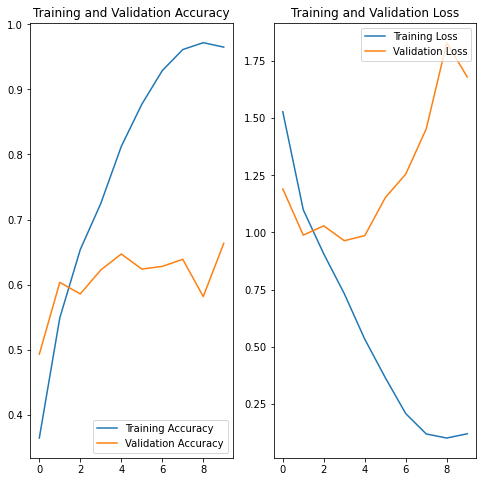

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

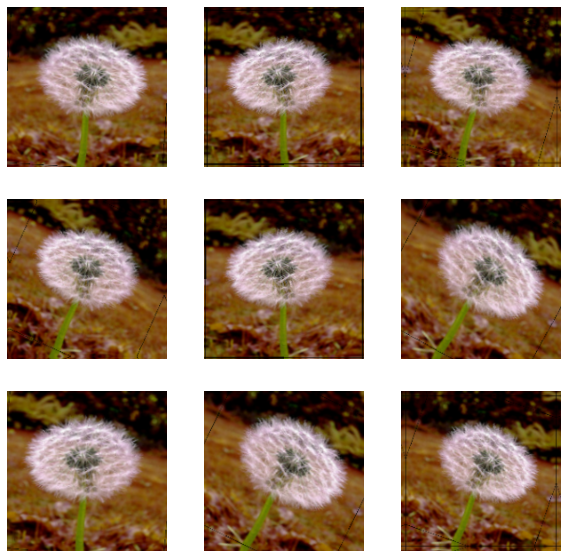

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

We will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


 1/92 [..............................] - ETA: 0s - loss: 1.6182 - accuracy: 0.2812

 6/92 [>.............................] - ETA: 0s - loss: 2.6125 - accuracy: 0.2083

11/92 [==>...........................] - ETA: 0s - loss: 2.1412 - accuracy: 0.2386

16/92 [====>.........................] - ETA: 0s - loss: 1.9595 - accuracy: 0.2324

21/92 [=====>........................] - ETA: 0s - loss: 1.8570 - accuracy: 0.2500

26/92 [=======>......................] - ETA: 0s - loss: 1.7744 - accuracy: 0.2812

31/92 [=========>....................] - ETA: 0s - loss: 1.7140 - accuracy: 0.2964

36/92 [==========>...................] - ETA: 0s - loss: 1.6633 - accuracy: 0.3099

41/92 [============>.................] - ETA: 0s - loss: 1.6200 - accuracy: 0.3178

46/92 [==============>...............] - ETA: 0s - loss: 1.5846 - accuracy: 0.3299

51/92 [===============>..............] - ETA: 0s - loss: 1.5393 - accuracy: 0.3504

56/92 [=================>............] - ETA: 0s - loss: 1.5174 - accuracy: 0.3604

61/92 [==================>...........] - ETA: 0s - loss: 1.4922 - accuracy: 0.3678

66/92 [====================>.........] - ETA: 0s - loss: 1.4699 - accuracy: 0.3779

71/92 [======================>.......] - ETA: 0s - loss: 1.4494 - accuracy: 0.3830

76/92 [=======================>......] - ETA: 0s - loss: 1.4393 - accuracy: 0.3894

81/92 [=========================>....] - ETA: 0s - loss: 1.4262 - accuracy: 0.3971

86/92 [===========================>..] - ETA: 0s - loss: 1.4146 - accuracy: 0.4027

91/92 [============================>.] - ETA: 0s - loss: 1.3952 - accuracy: 0.4132

92/92 [==============================] - 1s 13ms/step - loss: 1.3963 - accuracy: 0.4118 - val_loss: 1.1306 - val_accuracy: 0.5381


Epoch 2/15
 1/92 [..............................] - ETA: 0s - loss: 1.2395 - accuracy: 0.6250

 6/92 [>.............................] - ETA: 0s - loss: 1.1208 - accuracy: 0.5625

11/92 [==>...........................] - ETA: 0s - loss: 1.1298 - accuracy: 0.5341

16/92 [====>.........................] - ETA: 0s - loss: 1.1165 - accuracy: 0.5352

21/92 [=====>........................] - ETA: 0s - loss: 1.0740 - accuracy: 0.5512

26/92 [=======>......................] - ETA: 0s - loss: 1.0735 - accuracy: 0.5595

31/92 [=========>....................] - ETA: 0s - loss: 1.0857 - accuracy: 0.5559

36/92 [==========>...................] - ETA: 0s - loss: 1.0768 - accuracy: 0.5586

41/92 [============>.................] - ETA: 0s - loss: 1.0829 - accuracy: 0.5498

46/92 [==============>...............] - ETA: 0s - loss: 1.0809 - accuracy: 0.5553

51/92 [===============>..............] - ETA: 0s - loss: 1.0837 - accuracy: 0.5548

56/92 [=================>............] - ETA: 0s - loss: 1.0793 - accuracy: 0.5611

61/92 [==================>...........] - ETA: 0s - loss: 1.0711 - accuracy: 0.5658

66/92 [====================>.........] - ETA: 0s - loss: 1.0784 - accuracy: 0.5632

71/92 [======================>.......] - ETA: 0s - loss: 1.0820 - accuracy: 0.5605

76/92 [=======================>......] - ETA: 0s - loss: 1.0792 - accuracy: 0.5615

81/92 [=========================>....] - ETA: 0s - loss: 1.0728 - accuracy: 0.5662

86/92 [===========================>..] - ETA: 0s - loss: 1.0716 - accuracy: 0.5692

91/92 [============================>.] - ETA: 0s - loss: 1.0722 - accuracy: 0.5696

92/92 [==============================] - 1s 12ms/step - loss: 1.0720 - accuracy: 0.5695 - val_loss: 1.0125 - val_accuracy: 0.5899


Epoch 3/15
 1/92 [..............................] - ETA: 0s - loss: 0.8597 - accuracy: 0.6875

 6/92 [>.............................] - ETA: 0s - loss: 0.9775 - accuracy: 0.6510

11/92 [==>...........................] - ETA: 0s - loss: 1.0031 - accuracy: 0.6307

16/92 [====>.........................] - ETA: 0s - loss: 0.9894 - accuracy: 0.6426

21/92 [=====>........................] - ETA: 0s - loss: 1.0099 - accuracy: 0.6295

26/92 [=======>......................] - ETA: 0s - loss: 1.0143 - accuracy: 0.6166

31/92 [=========>....................] - ETA: 0s - loss: 1.0308 - accuracy: 0.6109

36/92 [==========>...................] - ETA: 0s - loss: 1.0343 - accuracy: 0.6033

41/92 [============>.................] - ETA: 0s - loss: 1.0176 - accuracy: 0.6105

46/92 [==============>...............] - ETA: 0s - loss: 1.0095 - accuracy: 0.6161

51/92 [===============>..............] - ETA: 0s - loss: 1.0106 - accuracy: 0.6145

56/92 [=================>............] - ETA: 0s - loss: 1.0260 - accuracy: 0.6115

61/92 [==================>...........] - ETA: 0s - loss: 1.0170 - accuracy: 0.6132

66/92 [====================>.........] - ETA: 0s - loss: 1.0113 - accuracy: 0.6126

71/92 [======================>.......] - ETA: 0s - loss: 1.0145 - accuracy: 0.6087

76/92 [=======================>......] - ETA: 0s - loss: 1.0070 - accuracy: 0.6126

81/92 [=========================>....] - ETA: 0s - loss: 1.0051 - accuracy: 0.6126

86/92 [===========================>..] - ETA: 0s - loss: 1.0116 - accuracy: 0.6082

91/92 [============================>.] - ETA: 0s - loss: 1.0105 - accuracy: 0.6098

92/92 [==============================] - 1s 12ms/step - loss: 1.0106 - accuracy: 0.6090 - val_loss: 0.9147 - val_accuracy: 0.6322


Epoch 4/15
 1/92 [..............................] - ETA: 0s - loss: 0.7617 - accuracy: 0.6562

 6/92 [>.............................] - ETA: 0s - loss: 0.9487 - accuracy: 0.6146

11/92 [==>...........................] - ETA: 0s - loss: 0.9261 - accuracy: 0.6193

16/92 [====>.........................] - ETA: 0s - loss: 0.9386 - accuracy: 0.6152

21/92 [=====>........................] - ETA: 0s - loss: 0.9249 - accuracy: 0.6190

26/92 [=======>......................] - ETA: 0s - loss: 0.9242 - accuracy: 0.6190

31/92 [=========>....................] - ETA: 0s - loss: 0.9285 - accuracy: 0.6240

36/92 [==========>...................] - ETA: 0s - loss: 0.9259 - accuracy: 0.6276

41/92 [============>.................] - ETA: 0s - loss: 0.9235 - accuracy: 0.6296

46/92 [==============>...............] - ETA: 0s - loss: 0.9271 - accuracy: 0.6298

51/92 [===============>..............] - ETA: 0s - loss: 0.9195 - accuracy: 0.6330

56/92 [=================>............] - ETA: 0s - loss: 0.9271 - accuracy: 0.6300

61/92 [==================>...........] - ETA: 0s - loss: 0.9283 - accuracy: 0.6312

66/92 [====================>.........] - ETA: 0s - loss: 0.9192 - accuracy: 0.6336

71/92 [======================>.......] - ETA: 0s - loss: 0.9163 - accuracy: 0.6343

76/92 [=======================>......] - ETA: 0s - loss: 0.9229 - accuracy: 0.6308

81/92 [=========================>....] - ETA: 0s - loss: 0.9182 - accuracy: 0.6354

86/92 [===========================>..] - ETA: 0s - loss: 0.9136 - accuracy: 0.6392

91/92 [============================>.] - ETA: 0s - loss: 0.9065 - accuracy: 0.6422

92/92 [==============================] - 1s 12ms/step - loss: 0.9072 - accuracy: 0.6434 - val_loss: 0.8791 - val_accuracy: 0.6635


Epoch 5/15
 1/92 [..............................] - ETA: 0s - loss: 1.2470 - accuracy: 0.4688

 6/92 [>.............................] - ETA: 0s - loss: 0.9029 - accuracy: 0.6458

11/92 [==>...........................] - ETA: 0s - loss: 0.8736 - accuracy: 0.6591

16/92 [====>.........................] - ETA: 0s - loss: 0.9071 - accuracy: 0.6562

21/92 [=====>........................] - ETA: 0s - loss: 0.8980 - accuracy: 0.6503

26/92 [=======>......................] - ETA: 0s - loss: 0.8628 - accuracy: 0.6719

31/92 [=========>....................] - ETA: 0s - loss: 0.8608 - accuracy: 0.6744

36/92 [==========>...................] - ETA: 0s - loss: 0.8580 - accuracy: 0.6766

41/92 [============>.................] - ETA: 0s - loss: 0.8608 - accuracy: 0.6733

46/92 [==============>...............] - ETA: 0s - loss: 0.8672 - accuracy: 0.6646

51/92 [===============>..............] - ETA: 0s - loss: 0.8687 - accuracy: 0.6626

56/92 [=================>............] - ETA: 0s - loss: 0.8635 - accuracy: 0.6659

61/92 [==================>...........] - ETA: 0s - loss: 0.8684 - accuracy: 0.6667

66/92 [====================>.........] - ETA: 0s - loss: 0.8645 - accuracy: 0.6683

71/92 [======================>.......] - ETA: 0s - loss: 0.8633 - accuracy: 0.6714

76/92 [=======================>......] - ETA: 0s - loss: 0.8627 - accuracy: 0.6712

81/92 [=========================>....] - ETA: 0s - loss: 0.8619 - accuracy: 0.6703

86/92 [===========================>..] - ETA: 0s - loss: 0.8624 - accuracy: 0.6680

91/92 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.6691

92/92 [==============================] - 1s 12ms/step - loss: 0.8632 - accuracy: 0.6689 - val_loss: 0.8943 - val_accuracy: 0.6349


Epoch 6/15
 1/92 [..............................] - ETA: 0s - loss: 0.5609 - accuracy: 0.8125

 6/92 [>.............................] - ETA: 0s - loss: 0.7091 - accuracy: 0.7188

11/92 [==>...........................] - ETA: 0s - loss: 0.7562 - accuracy: 0.6932

16/92 [====>.........................] - ETA: 0s - loss: 0.7598 - accuracy: 0.6934

21/92 [=====>........................] - ETA: 0s - loss: 0.7636 - accuracy: 0.6949

26/92 [=======>......................] - ETA: 0s - loss: 0.7846 - accuracy: 0.6942

31/92 [=========>....................] - ETA: 0s - loss: 0.8034 - accuracy: 0.6860

36/92 [==========>...................] - ETA: 0s - loss: 0.8034 - accuracy: 0.6879

41/92 [============>.................] - ETA: 0s - loss: 0.7990 - accuracy: 0.6887

46/92 [==============>...............] - ETA: 0s - loss: 0.7980 - accuracy: 0.6872

51/92 [===============>..............] - ETA: 0s - loss: 0.8091 - accuracy: 0.6829

56/92 [=================>............] - ETA: 0s - loss: 0.8033 - accuracy: 0.6883

61/92 [==================>...........] - ETA: 0s - loss: 0.8132 - accuracy: 0.6821

66/92 [====================>.........] - ETA: 0s - loss: 0.8131 - accuracy: 0.6806

71/92 [======================>.......] - ETA: 0s - loss: 0.8112 - accuracy: 0.6833

76/92 [=======================>......] - ETA: 0s - loss: 0.8184 - accuracy: 0.6815

81/92 [=========================>....] - ETA: 0s - loss: 0.8153 - accuracy: 0.6842

86/92 [===========================>..] - ETA: 0s - loss: 0.8134 - accuracy: 0.6844

91/92 [============================>.] - ETA: 0s - loss: 0.8151 - accuracy: 0.6832

92/92 [==============================] - 1s 12ms/step - loss: 0.8143 - accuracy: 0.6836 - val_loss: 0.9388 - val_accuracy: 0.6499


Epoch 7/15
 1/92 [..............................] - ETA: 0s - loss: 0.6958 - accuracy: 0.7188

 6/92 [>.............................] - ETA: 0s - loss: 0.8202 - accuracy: 0.7188

11/92 [==>...........................] - ETA: 0s - loss: 0.8296 - accuracy: 0.7074

16/92 [====>.........................] - ETA: 0s - loss: 0.8085 - accuracy: 0.7109

21/92 [=====>........................] - ETA: 0s - loss: 0.8397 - accuracy: 0.6920

26/92 [=======>......................] - ETA: 0s - loss: 0.8210 - accuracy: 0.6971

31/92 [=========>....................] - ETA: 0s - loss: 0.8275 - accuracy: 0.6865

36/92 [==========>...................] - ETA: 0s - loss: 0.8300 - accuracy: 0.6849

41/92 [============>.................] - ETA: 0s - loss: 0.8359 - accuracy: 0.6791

46/92 [==============>...............] - ETA: 0s - loss: 0.8260 - accuracy: 0.6827

51/92 [===============>..............] - ETA: 0s - loss: 0.8160 - accuracy: 0.6900

56/92 [=================>............] - ETA: 0s - loss: 0.8059 - accuracy: 0.6953

61/92 [==================>...........] - ETA: 0s - loss: 0.8051 - accuracy: 0.6931

66/92 [====================>.........] - ETA: 0s - loss: 0.8055 - accuracy: 0.6906

71/92 [======================>.......] - ETA: 0s - loss: 0.8120 - accuracy: 0.6895

76/92 [=======================>......] - ETA: 0s - loss: 0.8127 - accuracy: 0.6910

81/92 [=========================>....] - ETA: 0s - loss: 0.8113 - accuracy: 0.6923

86/92 [===========================>..] - ETA: 0s - loss: 0.8130 - accuracy: 0.6895

91/92 [============================>.] - ETA: 0s - loss: 0.8037 - accuracy: 0.6935

92/92 [==============================] - 1s 12ms/step - loss: 0.8051 - accuracy: 0.6928 - val_loss: 0.8243 - val_accuracy: 0.6907


Epoch 8/15
 1/92 [..............................] - ETA: 0s - loss: 0.7111 - accuracy: 0.7188

 6/92 [>.............................] - ETA: 0s - loss: 0.6711 - accuracy: 0.7448

11/92 [==>...........................] - ETA: 0s - loss: 0.7355 - accuracy: 0.7188

16/92 [====>.........................] - ETA: 0s - loss: 0.7271 - accuracy: 0.7207

21/92 [=====>........................] - ETA: 0s - loss: 0.7442 - accuracy: 0.7128

26/92 [=======>......................] - ETA: 0s - loss: 0.7475 - accuracy: 0.7115

31/92 [=========>....................] - ETA: 0s - loss: 0.7515 - accuracy: 0.7147

36/92 [==========>...................] - ETA: 0s - loss: 0.7465 - accuracy: 0.7135

41/92 [============>.................] - ETA: 0s - loss: 0.7399 - accuracy: 0.7142

46/92 [==============>...............] - ETA: 0s - loss: 0.7325 - accuracy: 0.7208

51/92 [===============>..............] - ETA: 0s - loss: 0.7394 - accuracy: 0.7188

56/92 [=================>............] - ETA: 0s - loss: 0.7377 - accuracy: 0.7204

61/92 [==================>...........] - ETA: 0s - loss: 0.7413 - accuracy: 0.7228

66/92 [====================>.........] - ETA: 0s - loss: 0.7421 - accuracy: 0.7188

71/92 [======================>.......] - ETA: 0s - loss: 0.7374 - accuracy: 0.7214

76/92 [=======================>......] - ETA: 0s - loss: 0.7428 - accuracy: 0.7183

81/92 [=========================>....] - ETA: 0s - loss: 0.7453 - accuracy: 0.7160

86/92 [===========================>..] - ETA: 0s - loss: 0.7456 - accuracy: 0.7151

91/92 [============================>.] - ETA: 0s - loss: 0.7474 - accuracy: 0.7145

92/92 [==============================] - 1s 12ms/step - loss: 0.7467 - accuracy: 0.7156 - val_loss: 0.7915 - val_accuracy: 0.6975


Epoch 9/15
 1/92 [..............................] - ETA: 0s - loss: 0.6289 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 0s - loss: 0.6822 - accuracy: 0.7188

11/92 [==>...........................] - ETA: 0s - loss: 0.6999 - accuracy: 0.7159

16/92 [====>.........................] - ETA: 0s - loss: 0.7459 - accuracy: 0.7129

21/92 [=====>........................] - ETA: 0s - loss: 0.7376 - accuracy: 0.7217

26/92 [=======>......................] - ETA: 0s - loss: 0.7296 - accuracy: 0.7224

31/92 [=========>....................] - ETA: 0s - loss: 0.7391 - accuracy: 0.7124

36/92 [==========>...................] - ETA: 0s - loss: 0.7342 - accuracy: 0.7124

41/92 [============>.................] - ETA: 0s - loss: 0.7348 - accuracy: 0.7147

46/92 [==============>...............] - ETA: 0s - loss: 0.7271 - accuracy: 0.7199

51/92 [===============>..............] - ETA: 0s - loss: 0.7332 - accuracy: 0.7161

56/92 [=================>............] - ETA: 0s - loss: 0.7345 - accuracy: 0.7164

61/92 [==================>...........] - ETA: 0s - loss: 0.7289 - accuracy: 0.7176

66/92 [====================>.........] - ETA: 0s - loss: 0.7226 - accuracy: 0.7210

71/92 [======================>.......] - ETA: 0s - loss: 0.7273 - accuracy: 0.7182

76/92 [=======================>......] - ETA: 0s - loss: 0.7201 - accuracy: 0.7236

81/92 [=========================>....] - ETA: 0s - loss: 0.7209 - accuracy: 0.7260

86/92 [===========================>..] - ETA: 0s - loss: 0.7223 - accuracy: 0.7281

91/92 [============================>.] - ETA: 0s - loss: 0.7200 - accuracy: 0.7293

92/92 [==============================] - 1s 12ms/step - loss: 0.7208 - accuracy: 0.7296 - val_loss: 0.7644 - val_accuracy: 0.6866


Epoch 10/15
 1/92 [..............................] - ETA: 0s - loss: 0.8356 - accuracy: 0.6875

 6/92 [>.............................] - ETA: 0s - loss: 0.7351 - accuracy: 0.7065

11/92 [==>...........................] - ETA: 0s - loss: 0.6943 - accuracy: 0.7442

16/92 [====>.........................] - ETA: 0s - loss: 0.7118 - accuracy: 0.7401

21/92 [=====>........................] - ETA: 0s - loss: 0.6962 - accuracy: 0.7485

26/92 [=======>......................] - ETA: 0s - loss: 0.6924 - accuracy: 0.7476

31/92 [=========>....................] - ETA: 0s - loss: 0.6991 - accuracy: 0.7419

36/92 [==========>...................] - ETA: 0s - loss: 0.7058 - accuracy: 0.7404

41/92 [============>.................] - ETA: 0s - loss: 0.7057 - accuracy: 0.7393

46/92 [==============>...............] - ETA: 0s - loss: 0.7092 - accuracy: 0.7370

51/92 [===============>..............] - ETA: 0s - loss: 0.7075 - accuracy: 0.7371

56/92 [=================>............] - ETA: 0s - loss: 0.7108 - accuracy: 0.7360

61/92 [==================>...........] - ETA: 0s - loss: 0.7131 - accuracy: 0.7330

66/92 [====================>.........] - ETA: 0s - loss: 0.7091 - accuracy: 0.7338

71/92 [======================>.......] - ETA: 0s - loss: 0.7044 - accuracy: 0.7372

76/92 [=======================>......] - ETA: 0s - loss: 0.7102 - accuracy: 0.7331

81/92 [=========================>....] - ETA: 0s - loss: 0.7072 - accuracy: 0.7334

86/92 [===========================>..] - ETA: 0s - loss: 0.7050 - accuracy: 0.7343

91/92 [============================>.] - ETA: 0s - loss: 0.7025 - accuracy: 0.7352

92/92 [==============================] - 1s 12ms/step - loss: 0.7001 - accuracy: 0.7364 - val_loss: 0.7482 - val_accuracy: 0.6935


Epoch 11/15
 1/92 [..............................] - ETA: 0s - loss: 0.6860 - accuracy: 0.6875

 6/92 [>.............................] - ETA: 0s - loss: 0.6282 - accuracy: 0.7554

11/92 [==>...........................] - ETA: 0s - loss: 0.5887 - accuracy: 0.7762

16/92 [====>.........................] - ETA: 0s - loss: 0.6137 - accuracy: 0.7619

21/92 [=====>........................] - ETA: 0s - loss: 0.6260 - accuracy: 0.7651

26/92 [=======>......................] - ETA: 0s - loss: 0.6209 - accuracy: 0.7658

31/92 [=========>....................] - ETA: 0s - loss: 0.6308 - accuracy: 0.7612

36/92 [==========>...................] - ETA: 0s - loss: 0.6406 - accuracy: 0.7570

41/92 [============>.................] - ETA: 0s - loss: 0.6424 - accuracy: 0.7577

46/92 [==============>...............] - ETA: 0s - loss: 0.6493 - accuracy: 0.7582

51/92 [===============>..............] - ETA: 0s - loss: 0.6429 - accuracy: 0.7580

56/92 [=================>............] - ETA: 0s - loss: 0.6548 - accuracy: 0.7528

61/92 [==================>...........] - ETA: 0s - loss: 0.6573 - accuracy: 0.7551

66/92 [====================>.........] - ETA: 0s - loss: 0.6619 - accuracy: 0.7543

71/92 [======================>.......] - ETA: 0s - loss: 0.6571 - accuracy: 0.7553

76/92 [=======================>......] - ETA: 0s - loss: 0.6582 - accuracy: 0.7541

81/92 [=========================>....] - ETA: 0s - loss: 0.6612 - accuracy: 0.7527

86/92 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.7515

91/92 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.7507

92/92 [==============================] - 1s 12ms/step - loss: 0.6661 - accuracy: 0.7507 - val_loss: 0.7971 - val_accuracy: 0.7098


Epoch 12/15
 1/92 [..............................] - ETA: 0s - loss: 0.8666 - accuracy: 0.7188

 6/92 [>.............................] - ETA: 0s - loss: 0.6975 - accuracy: 0.7188

11/92 [==>...........................] - ETA: 0s - loss: 0.6964 - accuracy: 0.7301

16/92 [====>.........................] - ETA: 0s - loss: 0.6802 - accuracy: 0.7402

21/92 [=====>........................] - ETA: 0s - loss: 0.6845 - accuracy: 0.7440

26/92 [=======>......................] - ETA: 0s - loss: 0.6768 - accuracy: 0.7476

31/92 [=========>....................] - ETA: 0s - loss: 0.6674 - accuracy: 0.7429

36/92 [==========>...................] - ETA: 0s - loss: 0.6529 - accuracy: 0.7483

41/92 [============>.................] - ETA: 0s - loss: 0.6412 - accuracy: 0.7477

46/92 [==============>...............] - ETA: 0s - loss: 0.6339 - accuracy: 0.7534

51/92 [===============>..............] - ETA: 0s - loss: 0.6300 - accuracy: 0.7525

56/92 [=================>............] - ETA: 0s - loss: 0.6287 - accuracy: 0.7567

61/92 [==================>...........] - ETA: 0s - loss: 0.6222 - accuracy: 0.7608

66/92 [====================>.........] - ETA: 0s - loss: 0.6307 - accuracy: 0.7605

71/92 [======================>.......] - ETA: 0s - loss: 0.6353 - accuracy: 0.7602

76/92 [=======================>......] - ETA: 0s - loss: 0.6405 - accuracy: 0.7574

81/92 [=========================>....] - ETA: 0s - loss: 0.6397 - accuracy: 0.7585

86/92 [===========================>..] - ETA: 0s - loss: 0.6452 - accuracy: 0.7569

91/92 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.7600

92/92 [==============================] - 1s 12ms/step - loss: 0.6381 - accuracy: 0.7609 - val_loss: 0.7197 - val_accuracy: 0.7248


Epoch 13/15
 1/92 [..............................] - ETA: 0s - loss: 0.5591 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.5209 - accuracy: 0.7812

11/92 [==>...........................] - ETA: 0s - loss: 0.5870 - accuracy: 0.7585

16/92 [====>.........................] - ETA: 0s - loss: 0.5796 - accuracy: 0.7656

21/92 [=====>........................] - ETA: 0s - loss: 0.5926 - accuracy: 0.7530

26/92 [=======>......................] - ETA: 0s - loss: 0.5925 - accuracy: 0.7584

31/92 [=========>....................] - ETA: 0s - loss: 0.5977 - accuracy: 0.7611

36/92 [==========>...................] - ETA: 0s - loss: 0.6117 - accuracy: 0.7552

41/92 [============>.................] - ETA: 0s - loss: 0.6114 - accuracy: 0.7584

46/92 [==============>...............] - ETA: 0s - loss: 0.6216 - accuracy: 0.7568

51/92 [===============>..............] - ETA: 0s - loss: 0.6176 - accuracy: 0.7605

56/92 [=================>............] - ETA: 0s - loss: 0.6098 - accuracy: 0.7635

61/92 [==================>...........] - ETA: 0s - loss: 0.6122 - accuracy: 0.7613

66/92 [====================>.........] - ETA: 0s - loss: 0.6041 - accuracy: 0.7628

71/92 [======================>.......] - ETA: 0s - loss: 0.6077 - accuracy: 0.7619

76/92 [=======================>......] - ETA: 0s - loss: 0.6055 - accuracy: 0.7624

81/92 [=========================>....] - ETA: 0s - loss: 0.6090 - accuracy: 0.7632

86/92 [===========================>..] - ETA: 0s - loss: 0.6130 - accuracy: 0.7624

91/92 [============================>.] - ETA: 0s - loss: 0.6187 - accuracy: 0.7593

92/92 [==============================] - 1s 12ms/step - loss: 0.6196 - accuracy: 0.7582 - val_loss: 0.6956 - val_accuracy: 0.7302


Epoch 14/15
 1/92 [..............................] - ETA: 0s - loss: 0.5288 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 0s - loss: 0.5483 - accuracy: 0.7708

11/92 [==>...........................] - ETA: 0s - loss: 0.5712 - accuracy: 0.7756

16/92 [====>.........................] - ETA: 0s - loss: 0.5518 - accuracy: 0.7852

21/92 [=====>........................] - ETA: 0s - loss: 0.5873 - accuracy: 0.7738

26/92 [=======>......................] - ETA: 0s - loss: 0.5833 - accuracy: 0.7800

31/92 [=========>....................] - ETA: 0s - loss: 0.5777 - accuracy: 0.7846

36/92 [==========>...................] - ETA: 0s - loss: 0.5932 - accuracy: 0.7745

41/92 [============>.................] - ETA: 0s - loss: 0.5887 - accuracy: 0.7753

46/92 [==============>...............] - ETA: 0s - loss: 0.6025 - accuracy: 0.7691

51/92 [===============>..............] - ETA: 0s - loss: 0.6076 - accuracy: 0.7679

56/92 [=================>............] - ETA: 0s - loss: 0.6116 - accuracy: 0.7629

61/92 [==================>...........] - ETA: 0s - loss: 0.6112 - accuracy: 0.7629

66/92 [====================>.........] - ETA: 0s - loss: 0.6083 - accuracy: 0.7628

71/92 [======================>.......] - ETA: 0s - loss: 0.6095 - accuracy: 0.7619

76/92 [=======================>......] - ETA: 0s - loss: 0.6062 - accuracy: 0.7632

81/92 [=========================>....] - ETA: 0s - loss: 0.6089 - accuracy: 0.7639

86/92 [===========================>..] - ETA: 0s - loss: 0.6082 - accuracy: 0.7660

91/92 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.7655

92/92 [==============================] - 1s 12ms/step - loss: 0.6130 - accuracy: 0.7653 - val_loss: 0.7472 - val_accuracy: 0.7098


Epoch 15/15
 1/92 [..............................] - ETA: 0s - loss: 0.5425 - accuracy: 0.8125

 6/92 [>.............................] - ETA: 0s - loss: 0.5127 - accuracy: 0.8229

11/92 [==>...........................] - ETA: 0s - loss: 0.5600 - accuracy: 0.8011

16/92 [====>.........................] - ETA: 0s - loss: 0.5352 - accuracy: 0.8086

21/92 [=====>........................] - ETA: 0s - loss: 0.5175 - accuracy: 0.8080

26/92 [=======>......................] - ETA: 0s - loss: 0.5469 - accuracy: 0.7909

31/92 [=========>....................] - ETA: 0s - loss: 0.5541 - accuracy: 0.7883

36/92 [==========>...................] - ETA: 0s - loss: 0.5638 - accuracy: 0.7899

41/92 [============>.................] - ETA: 0s - loss: 0.5616 - accuracy: 0.7904

46/92 [==============>...............] - ETA: 0s - loss: 0.5567 - accuracy: 0.7894

51/92 [===============>..............] - ETA: 0s - loss: 0.5678 - accuracy: 0.7868

56/92 [=================>............] - ETA: 0s - loss: 0.5742 - accuracy: 0.7835

61/92 [==================>...........] - ETA: 0s - loss: 0.5714 - accuracy: 0.7869

66/92 [====================>.........] - ETA: 0s - loss: 0.5745 - accuracy: 0.7874

71/92 [======================>.......] - ETA: 0s - loss: 0.5700 - accuracy: 0.7870

76/92 [=======================>......] - ETA: 0s - loss: 0.5742 - accuracy: 0.7858

81/92 [=========================>....] - ETA: 0s - loss: 0.5798 - accuracy: 0.7810

86/92 [===========================>..] - ETA: 0s - loss: 0.5813 - accuracy: 0.7799

91/92 [============================>.] - ETA: 0s - loss: 0.5794 - accuracy: 0.7789

92/92 [==============================] - 1s 12ms/step - loss: 0.5786 - accuracy: 0.7796 - val_loss: 0.6935 - val_accuracy: 0.7357


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

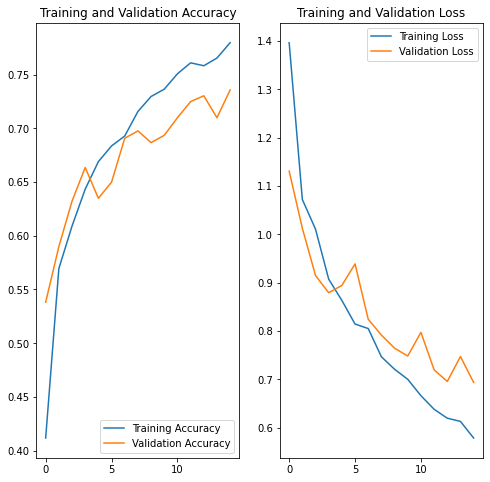

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

122880/117948 [===============================] - 0s 0us/step


This image most likely belongs to sunflowers with a 93.12 percent confidence.
